# Pipeline and Pickle File Knowledge provement Project

### Skills in this Notebook shown:
- Data Preprocessing
- Put all Data Processing Steps into a ColumnTransformer
- Build Pipelines around different Column Transformers for Sequencing Operations
- Embedd different Models into my ColumnTransformer Pipeline
- Use Pickle Files to store Predictions or results


I use the famous "Palmer Penguins" Dataset to show my skills in Modelling with Pipelines 
Make sure to get your copy of the Dataset using "pip install palmerpenguins" and import them into your Library before starting

### See Descriptions in the Notebook and Code commentary for all Info you need about how i gathered Pipeline and Transforming Skills

- IN the pure_pipeline_code.py file you will find the whole Process in one Python file Code Block
- IN this Notebook you will find a commented and more detailed Version of the builded Pipelines

In [55]:
# Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

# new utils
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

from sklearn.metrics import classification_report, roc_auc_score, accuracy_score


# make sure to get the Example Dataset with pip install palmerpenguins
from palmerpenguins import load_penguins

# to visualize the column transformer and pipeline
set_config(display='diagram')

# Pickle Module for Showcase
import pickle

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

### Get the Data from your Palmerpenguins Dataset
### Perform some EDA on the Dataset to get a feeling for what we will need to fix


In [56]:
# Read in the Data and look at it
penguins = load_penguins()
penguins.head(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [57]:
# look how much Data is missing 
penguins.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64

<Axes: >

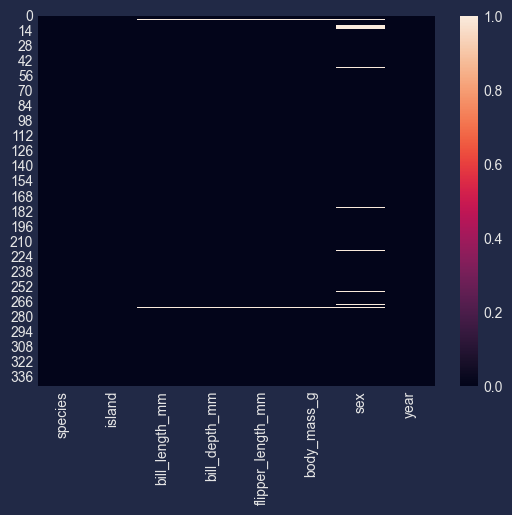

In [58]:
# look in which columns the missing values are
sns.heatmap(penguins.isna())

### Seems like 2 Rows nearly completely miss data, we will drop them. 
### The sex Column has 12 missing values. We will impute and encode them later within a pipeline

In [59]:
# 2 rows missing Data nearly completely - we just drop them, when bill_lenght_mm is empty
penguins.dropna(subset = "bill_length_mm", inplace=True)

In [60]:
# We will keep the 9 missing entries in Sex to showcase Imputing and Encoding Pipeline
penguins.sex.isna().value_counts()

sex
False    333
True       9
Name: count, dtype: int64

After dropping the whole row where bill_length_mm is "na" still 9 sex entries are missing

### Define Target and Features and make the Train Test Split to avoid Data Leakage when we Impute or alter the Dataset

In [61]:
# Extract Target and Features
y = penguins["species"]

X = penguins[['island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'year']]

penguins.columns

Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'year'],
      dtype='object')

In [62]:
# Train Test Split before our Transformations to Avoid Data Leakage

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= .2, random_state=88)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((273, 7), (69, 7), (273,), (69,))

In [63]:
# Group Features to Numerical and Categorical
cat_cols = X_train.select_dtypes(include="object").columns
num_cols = X_train.select_dtypes(include="number").columns

print(f"Categorical Columns are: {cat_cols}\nNumerical Columns are: {num_cols}")


Categorical Columns are: Index(['island', 'sex'], dtype='object')
Numerical Columns are: Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g',
       'year'],
      dtype='object')


### Lets look at the Data and identify what we can Preprocess
For now we will:
- Encode our cat_cols
- Scale bill length and flipper length
- bin the Body_mass into 5 categories (we could scale them as well) (Just to show more Variations)

In [64]:
# Look at the X head and see what we can Transform
X_train.head()


,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
180,Biscoe,48.2,14.3,210.0,4600.0,female,2007
221,Biscoe,50.7,15.0,223.0,5550.0,male,2008
323,Dream,49.0,19.6,212.0,4300.0,male,2009
299,Dream,50.6,19.4,193.0,3800.0,male,2007
16,Torgersen,38.7,19.0,195.0,3450.0,female,2007


### Create a Transformer List
We create a List of Tuples for our Transformer. 

The Tuples consist of three elements each
1. Element: You can Name the Operation
2. Element: call the Transformer Object
3. Element: specify which column you want to apply transformation

In [65]:
# We will Encode our Cat_cols
# Scale our bill lenght and flipper length
# Bin the Body_mass into 5 categories for showcase (we could Scale them as well)

transformer = [("ohe", OneHotEncoder(drop="first"),cat_cols),
               ("scaler", RobustScaler(), ["bill_length_mm", "flipper_length_mm"]),
               ("binner", KBinsDiscretizer(), ["body_mass_g"])
               ]

### Make a Column Transformer() Object out of your Transformer List
- we sucessfully made a Column Transformer object out of our List
- lets Visualize, what we have done so far

In [66]:
# Now we Instantiate a Column Transformer() object

column_transformer = ColumnTransformer(transformer, 
                                       remainder="drop")

# visualize our column_transformer instance
column_transformer

ColumnTransformer(transformers=[('ohe', OneHotEncoder(drop='first'),
                                 Index(['island', 'sex'], dtype='object')),
                                ('scaler', RobustScaler(),
                                 ['bill_length_mm', 'flipper_length_mm']),
                                ('binner', KBinsDiscretizer(),
                                 ['body_mass_g'])])

# Building a Pipeline()

 We still need to impute missing values in sex, but if we do this in the 1 tansformer we would create an imputed copy of sex and a one-hot encoded with missing values 

 - With a Pipeline() we can sequentially apply multiple transformers on the same columns

In [67]:
# Lets define a pipeline to impute and Encode Sex
# Fill missing values in Sex with the most frequent and Encode the column

sex_pipeline = Pipeline(steps =
                        [("imputer", SimpleImputer(strategy= "most_frequent")),
                         ("sex_ohe", OneHotEncoder(drop="first"))
                         ])

To showcase the Pipeline Skills Step by Step, we make a 2nd Transformer where we include this pipeline

In [68]:
# 2 column transformer including the sex pipeline

transformer_2 = [("sex_pipeline", sex_pipeline, ["sex"]),
                 ("ohe", OneHotEncoder(drop = "first"), ["island"]),
                 ("scaler", RobustScaler(), ["bill_length_mm", "flipper_length_mm"]),
                 ("binner", KBinsDiscretizer(), ["body_mass_g"])
                 ]
# new Column Transformer Instance
column_transformer_2 = ColumnTransformer(transformer_2, remainder="drop")

# Visualize what we have done so far
column_transformer_2

ColumnTransformer(transformers=[('sex_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('sex_ohe',
                                                  OneHotEncoder(drop='first'))]),
                                 ['sex']),
                                ('ohe', OneHotEncoder(drop='first'),
                                 ['island']),
                                ('scaler', RobustScaler(),
                                 ['bill_length_mm', 'flipper_length_mm']),
                                ('binner', KBinsDiscretizer(),
                                 ['body_mass_g'])])

### So far so Good...

### Lets Integrate a custom function into our Transformer 

Let's say we also needed to convert the body mass from grams to Kilograms before binning (does make no sense, but its good for showcase Knowledge about Transformers

In [69]:
# Grams to Kilograms function
def g_to_kg(g):
    return g/ 1000

In [70]:
# define our pipeline for bodymass transformations
mass_pipeline = Pipeline(steps = 
                         [("converter", FunctionTransformer(g_to_kg)),
                          ("binning", KBinsDiscretizer())
                          ])

In [71]:
# include the mass pipeline in our transformer - we name it transformer_3 here

transformer_3 = [("sex_pipeline", sex_pipeline, ["sex"]),
                 ("mass_pipeline", mass_pipeline, ["body_mass_g"]),
                 ("ohe", OneHotEncoder(drop="first"), ["island"]),
                 ("scaler", RobustScaler(), ["bill_length_mm", "flipper_length_mm"])
                 ]

# make our new Column Transformer instance

column_transformer_3 = ColumnTransformer(transformer_3,
                                         remainder="drop")

# lets look at the actual state of our automation process
column_transformer_3

ColumnTransformer(transformers=[('sex_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('sex_ohe',
                                                  OneHotEncoder(drop='first'))]),
                                 ['sex']),
                                ('mass_pipeline',
                                 Pipeline(steps=[('converter',
                                                  FunctionTransformer(func=<function g_to_kg at 0x00000187714019E0>)),
                                                 ('binning',
                                                  KBinsDiscretizer())]),
                                 ['body_mass_g']),
                                ('ohe', OneHotEncoder(drop='first'),
                                 ['island']),
                                ('scaler', RobustScaler(),
                                 ['bill_length_mm', 'flipper_length_mm'])])

# Lets try out our Preprocessing Pipeline 

column_transformer_3 was our latest Version, we will use this one

we give our X and y here the prefix fe for "feature engineered"

In [72]:
# Fit and Transform the Column(Transformer) ONLY on Training Data
X_train_fe = column_transformer_3.fit_transform(X_train, y_train)

# Use it to ONLY Transform the test Data
X_test_fe = column_transformer_3.transform(X_test)

In [73]:
# Lets have a look, how our Data looks like now
X_train_fe = pd.DataFrame(X_train_fe)
X_train_fe.head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.336957,0.48
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.608696,1.00
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.423913,0.56
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.597826,-0.20
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.695652,-0.12


## Looks Good! Then lets Nest the Pipelines into Multiple Models for quick performance Analysis

Lets build Models on Top of our Preprocessing Pipeline

### We Start with a simple Logistic Regression Pipeline

In [74]:
# nest the Model into Pipeline for quick Processing and Modelling

log_reg_pipeline = Pipeline(steps = 
                            [("column_transformer", column_transformer_3),
                             ("log_reg", LogisticRegression(class_weight="balanced"))
                             ])

# Fit The Model with our Pipeline
log_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('sex_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('sex_ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['sex']),
                                                 ('mass_pipeline',
                                                  Pipeline(steps=[('converter',
                                                                   FunctionTransformer(func=<function g_to_kg at 0x00000187714019E0>)),
                                                                  ('binning',
                                                                   KBinsDiscretizer())]),
                                                  ['body_mass_g']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['island']),
                                                 ('scaler', RobustScaler(),
                                                  ['bill_length_mm',
                                                   'flipper_length_mm'])])),
                ('log_reg', LogisticRegression(class_weight='balanced'))])

### Random Forest Pipeline


In [75]:
# do the same with random Forest Classifier in the end
forest_pipeline = Pipeline(steps = 
                           [("column_transformer", column_transformer_3),
                            ("forest", RandomForestClassifier(n_estimators=15, max_depth=5))
                           ])


# Fit The Model with our Pipeline
forest_pipeline.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('sex_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('sex_ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['sex']),
                                                 ('mass_pipeline',
                                                  Pipeline(steps=[('converter',
                                                                   FunctionTransformer(func=<function g_to_kg at 0x00000187714019E0>)),
                                                                  ('binning',
                                                                   KBinsDiscretizer())]),
                                                  ['body_mass_g']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['island']),
                                                 ('scaler', RobustScaler(),
                                                  ['bill_length_mm',
                                                   'flipper_length_mm'])])),
                ('forest',
                 RandomForestClassifier(max_depth=5, n_estimators=15))])

### SVC Pipeline

In [76]:
# do the same again for a SVC Model
svc_pipeline = Pipeline(steps=
                        [("column_transformer", column_transformer_3),
                         ("svc", SVC(probability=True))
                         ])

# Fit the SVC Model
svc_pipeline.fit(X_train,y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('sex_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('sex_ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['sex']),
                                                 ('mass_pipeline',
                                                  Pipeline(steps=[('converter',
                                                                   FunctionTransformer(func=<function g_to_kg at 0x00000187714019E0>)),
                                                                  ('binning',
                                                                   KBinsDiscretizer())]),
                                                  ['body_mass_g']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['island']),
                                                 ('scaler', RobustScaler(),
                                                  ['bill_length_mm',
                                                   'flipper_length_mm'])])),
                ('svc', SVC(probability=True))])

### OK Lets Store the Predictions of our Models in a way, that we could later use them for Error Analysis

In [77]:
# Dictionary of my Model Proba Predictions
models_proba = {
    "LogisticRegression": log_reg_pipeline.predict_proba(X_test),
    "Random Forrest": forest_pipeline.predict_proba(X_test),
    "SVC": svc_pipeline.predict_proba(X_test)
}

models_pred = {
    "LogisticRegression": log_reg_pipeline.predict(X_test),
    "Random Forrest": forest_pipeline.predict(X_test),
    "SVC": svc_pipeline.predict(X_test)
}

### Just for Showcase here, we can Use the Pickle Files, to transport and store our Data for later use

We will store for now:
- models_proba.pkl with the probabilitys from our model for a class
- models_pred - the final predictions of our models on the Test Set

### For the models_proba.pkl File

In [78]:
# Save the dictionary to a pickle file
with open('models_proba.pkl', 'wb') as f:
    pickle.dump(models_proba, f)

In [79]:
# Load the dictionary from the pickle file
with open('models_proba.pkl', 'rb') as f:
    loaded_probas = pickle.load(f)

# Now, loaded_models is the same as the original models dictionary

### For the models_pred.pkl File

In [80]:
# Save the dictionary to a pickle file
with open('models_pred.pkl', 'wb') as f:
    pickle.dump(models_pred, f)

In [81]:
# Load the dictionary from the pickle file
with open('models_pred.pkl', 'rb') as f:
    loaded_preds = pickle.load(f)

# Now, loaded_models is the same as the original models dictionary

### Finally let's plot the ROC AUC Score and the Accuracy of each of our Models

In Real world Scenario we could also Add a Grid Search or more custom parameters to each of our Models within the Pipeline
But for now this is enough. 
We will reuse pipelines in other Projects anyway

Now we calculate the final Metric and make a plot out of our Models accuracy

ROC AUC score for LogisticRegression: 1.00
ROC AUC score for Random Forrest: 1.00
ROC AUC score for SVC: 1.00
Acurracy Score for LogisticRegression: 1.0
Acurracy Score for Random Forrest: 0.9855072463768116
Acurracy Score for SVC: 1.0


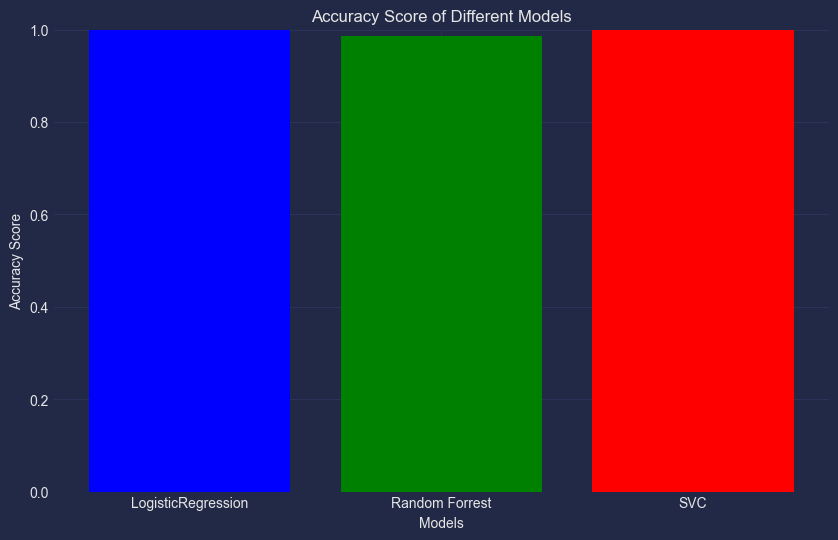

In [82]:
# Compute and print ROC AUC scores
for model_name, y_pred_proba in models_proba.items():
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    print(f'ROC AUC score for {model_name}: {roc_auc:.2f}')

# Compute Accuracy Score for each Model and Store it in Dict for Plot
accuracies = {}
for model_name, y_pred in models_pred.items():
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[model_name] = accuracy
    print(f"Acurracy Score for {model_name}:", accuracy)

# Plot the Accuracies of my Different Models
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score of Different Models')
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1
plt.show()
